# Exploration of selecting gene sets for trait relevance score
1. Compute TRS with different gene set choice
2. Using metrics to compare different gene sets
3. Compare gene sets using enrichment in known celltype -- disease pair

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from os.path import join
import pickle

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md
from scTRS.gene_sets import GeneSet

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0


In [2]:
#### Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home12/khou/scTRS_results/'
GENE_SETS_PATH = '/n/home12/khou/scTRS/gene_sets/out'

# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=13.6s
# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]
# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: 

In [3]:
def parse_config(config):
    geneset_name, param = config.rsplit('_', 1)
    if geneset_name == 'MAGMA':
        geneset_name = 'magma_108'
        filter_func = lambda df : df.nsmallest(int(param), 'FDR')
    if geneset_name == 'OLDMAGMA':
        geneset_name = 'magma_107'
        filter_func = lambda df : df.nsmallest(int(param), 'SCORE')
    elif geneset_name == 'TWAS':
        geneset_name = 'twas_kushal'
        filter_func = lambda df : df.nsmallest(int(param), 'FDR')
    elif geneset_name == 'GWAS_MAX_ABS_Z':
        geneset_name = 'gwas_max_abs_z'
        filter_func = lambda df : df.nlargest(int(param), 'MAX_ABS_Z')
    elif geneset_name == 'HESS':
        geneset_name = 'hess'
        filter_func = lambda df : df.nlargest(int(param), 'ESTIMATE')
    return geneset_name, filter_func

In [4]:
dic_genesets = dict()
for name in ['magma_108', 'gwas_max_abs_z', 'hess', 'magma_107']:
    dic_genesets[name] = GeneSet(root_dir = GENE_SETS_PATH, geneset_name=name, verbose=True)
    
trait_list = list(set.intersection(*map(set, [gs.available_traits() for gs in dic_genesets.values()])))

trait_list = sorted(list(set(['PASS_FastingGlucose_Manning', 'PASS_Triglycerides', 'PASS_HDL',
       'UKB_460K.disease_CARDIOVASCULAR', 'UKB_460K.mental_NEUROTICISM',
       'PASS_AlzheimersProxy_Marioni2018', 'PASS_Neuroticism', 'PASS_LDL',
       'PASS_Schizophrenia', 'UKB_460K.disease_T2D',
       'UKB_460K.cov_SMOKING_STATUS', 'UKB_460K.bp_SYSTOLICadjMEDz',
       'PASS_MDD_Wray2018', 'PASS_Intelligence_SavageJansen2018',
       'PASS_VerbalNumericReasoning_Davies2018', 'UKB_460K.body_BMIz',
       'PASS_ReactionTime_Davies2018', 'PASS_Bipolar_Disorder',
       'UKB_460K.other_MORNINGPERSON', 'PASS_SCZvsBD_Ruderfer2018']) & set(trait_list)))

Reading 255 from magma_108
Reading 170 from gwas_max_abs_z
Reading 166 from hess
Reading 169 from magma_107


# Compute the TRS

In [5]:
PRE_COMPUTE = True

if PRE_COMPUTE is False:
    config_list = []
    for method in ['MAGMA', 'OLDMAGMA', 'GWAS_MAX_ABS_Z', 'HESS']:
        config_list.extend([f'{method}_{num}' for num in [50, 100, 500]])

    all_dic_results = {'mean': dict(), 'vst': dict()}
    NUM_REPEATED = 3
    # for each trs_option
    for trs_opt in all_dic_results:
        # for each configuration
        for config in config_list:
            all_dic_results[trs_opt][config] = dict()
            # parser config
            geneset_name, filter_func = parse_config(config)
            geneset = GeneSet(root_dir = GENE_SETS_PATH, geneset_name=geneset_name, verbose=True)

            for trait in trait_list:

                all_dic_results[trs_opt][config][trait] = dict()
                trait_gene_df = geneset.query_trait(trait)
                trait_gene_df = filter_func(trait_gene_df)

                all_dic_results[trs_opt][config][trait]['geneset'] = trait_gene_df

                print(len(trait_gene_df))

                trait_gene_list = np.unique(trait_gene_df.GENE.values)
                if len(trait_gene_list) == 0:
                    continue

                all_dic_results[trs_opt][config][trait]['trs_ep'] = []
                for rep_i in range(NUM_REPEATED):
                    md.score_cell(data_facs_ct, trait_gene_list, suffix='',
                          ctrl_opt='mean_match', trs_opt=trs_opt, bc_opt='empi',
                          n_ctrl=10, n_genebin=200, random_seed=rep_i,
                          return_list=['trs_ep'], verbose=False)

                    all_dic_results[trs_opt][config][trait]['trs_ep'].append(data_facs_ct.obs['trs_ep'].values.copy())

    with open(join(RESULT_PATH, 'dic_results_100520.pkl'), 'wb') as f:
        pickle.dump(all_dic_results, f)

else:
    with open(join(RESULT_PATH, 'dic_results_100520.pkl'), 'rb') as f:
        all_dic_results = pickle.load(f)


In [6]:
df_obs = data_facs_ct.obs.copy()
dic_tissue_num_cells = df_obs.groupby(['tissue']).agg({'cell':len})['cell'].to_dict()
dic_tissue_celltype_num_cells = df_obs.groupby(['tissue_celltype']).agg({'cell':len})['cell'].to_dict()

tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

# Overview of number of association for different methods

In [7]:
from matplotlib import colors
from IPython.display import display

def background_gradient(s, value_func, m=None, M=None, cmap='PuBu', low=0, high=0.8):
    """
    s: the table
    value_func: a function that transform each cell in the table to a numeric
    """
    # s = s.apply(lambda x : int(x.split('±')[0]) if pd.notnull(x) else 0)
    s = s.apply(value_func)
    if m is None:
        m = s.min().min()
    if M is None:
        M = s.max().max()
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = s.apply(norm)

    cm = plt.cm.get_cmap(cmap)
    c = normed.apply(lambda x: colors.rgb2hex(cm(x)))
    ret = c.apply(lambda x: 'background-color: %s' % x)
    return ret


In [8]:
for trs_opt in all_dic_results:
    print(f'TRS option: {trs_opt}')
    dic_results = all_dic_results[trs_opt]
    config_list = list(dic_results.keys())
    df = pd.DataFrame(index=trait_list, columns=config_list, data=np.nan)

    for config in config_list:
        config_trait_list = dic_results[config].keys()
        for i_trait, trait in enumerate(config_trait_list):
            if len(dic_results[config][trait]['geneset']) == 0:
                # if no genes in the gene set
                continue
            num_discovery = []
            for v_p in dic_results[config][trait]['trs_ep']:
                v_fdr = multipletests(v_p, method='fdr_bh')[1]
                num_discovery.append((v_fdr < 0.25).sum())
            df.loc[trait, config] = f"{int(np.mean(num_discovery))}" + "±" + f"{int(np.std(num_discovery) * 2)}" + ' (' + str(dic_results[config][trait]['geneset'].shape[0]) + ')'

    display(df.style.apply(lambda s: background_gradient(s, value_func = (lambda x : int(x.split('±')[0]) if pd.notnull(x) else 0)), axis=1))
    
    mean_df = df.applymap(lambda x : int(x.split('±')[0]) if pd.notnull(x) else 0)
    
    print('sum of the proportion')
    print((mean_df.T / mean_df.sum(axis=1)).sum(axis=1))
    
    print('sum of #discoveries')
    print(mean_df.sum(axis=0))
    
    # maximum within the methods
    max_df = pd.concat([mean_df.loc[:, mean_df.columns.str.startswith('MAGMA')].max(axis=1),
                        mean_df.loc[:, mean_df.columns.str.startswith('GWAS_MAX_ABS_Z')].max(axis=1),
                        mean_df.loc[:, mean_df.columns.str.startswith('OLDMAGMA')].max(axis=1),
                        mean_df.loc[:, mean_df.columns.str.startswith('HESS')].max(axis=1)], axis=1)
    max_df.columns = ['MAGMA', 'GWAS_MAX_ABS_Z', 'OLDMAGMA', 'HESS']
    display(max_df.style.apply(lambda s : background_gradient(s, lambda x : x), axis=1))

TRS option: mean


,MAGMA_50,MAGMA_100,MAGMA_500,OLDMAGMA_50,OLDMAGMA_100,OLDMAGMA_500,GWAS_MAX_ABS_Z_50,GWAS_MAX_ABS_Z_100,GWAS_MAX_ABS_Z_500,HESS_50,HESS_100,HESS_500
PASS_AlzheimersProxy_Marioni2018,0±0 (50),0±1 (100),0±0 (500),0±0 (50),9±14 (100),0±0 (500),0±0 (50),0±0 (100),0±0 (500),0±0 (50),0±0 (100),0±0 (500)
PASS_Bipolar_Disorder,0±0 (50),0±0 (100),0±0 (500),0±0 (50),4±8 (100),1±0 (500),32±13 (50),79±7 (100),244±119 (500),265±10 (50),502±49 (100),531±88 (500)
PASS_FastingGlucose_Manning,48±87 (50),31±29 (100),128±16 (500),4±7 (50),72±4 (100),149±45 (500),365±52 (50),519±152 (100),665±46 (500),664±151 (50),532±109 (100),488±81 (500)
PASS_HDL,309±82 (50),47±90 (100),0±0 (500),519±48 (50),99±209 (100),0±0 (500),532±16 (50),10±12 (100),31±87 (500),4±6 (50),1±1 (100),0±0 (500)
PASS_Intelligence_SavageJansen2018,3±4 (50),8±0 (100),509±80 (500),1±3 (50),12±2 (100),816±90 (500),0±0 (50),0±0 (100),792±28 (500),224±43 (50),321±38 (100),1592±149 (500)
PASS_LDL,0±0 (50),62±99 (100),16±0 (500),683±28 (50),129±226 (100),311±43 (500),1±3 (50),54±127 (100),0±0 (500),0±0 (50),0±0 (100),5±5 (500)
PASS_MDD_Wray2018,199±24 (50),111±35 (100),203±16 (500),258±94 (50),252±56 (100),252±164 (500),217±55 (50),384±47 (100),598±46 (500),278±127 (50),472±130 (100),553±25 (500)
PASS_Neuroticism,0±1 (50),31±5 (100),418±52 (500),7±5 (50),29±17 (100),365±62 (500),1±1 (50),333±35 (100),252±76 (500),64±92 (50),450±61 (100),384±14 (500)
PASS_ReactionTime_Davies2018,0±0 (50),0±1 (100),358±70 (500),0±0 (50),0±0 (100),400±91 (500),2±0 (50),1±3 (100),687±162 (500),215±90 (50),589±140 (100),1140±227 (500)
PASS_SCZvsBD_Ruderfer2018,0±0 (50),3±4 (100),13±6 (500),0±0 (50),66±91 (100),58±28 (500),0±1 (50),23±13 (100),507±102 (500),33±38 (50),130±142 (100),770±39 (500)


sum of the proportion
MAGMA_50              0.572250
MAGMA_100             0.457398
MAGMA_500             1.440532
OLDMAGMA_50           1.517062
OLDMAGMA_100          2.154703
OLDMAGMA_500          2.102745
GWAS_MAX_ABS_Z_50     0.839992
GWAS_MAX_ABS_Z_100    1.660965
GWAS_MAX_ABS_Z_500    2.469015
HESS_50               1.123811
HESS_100              1.927430
HESS_500              3.734096
dtype: float64
sum of #discoveries
MAGMA_50               2402
MAGMA_100              2142
MAGMA_500              5491
OLDMAGMA_50            3472
OLDMAGMA_100           2847
OLDMAGMA_500           7336
GWAS_MAX_ABS_Z_50      2579
GWAS_MAX_ABS_Z_100     3030
GWAS_MAX_ABS_Z_500     8115
HESS_50                4738
HESS_100               6942
HESS_500              12863
dtype: int64


,MAGMA,GWAS_MAX_ABS_Z,OLDMAGMA,HESS
PASS_AlzheimersProxy_Marioni2018,0,0,9,0
PASS_Bipolar_Disorder,0,244,4,531
PASS_FastingGlucose_Manning,128,665,149,664
PASS_HDL,309,532,519,4
PASS_Intelligence_SavageJansen2018,509,792,816,1592
PASS_LDL,62,54,683,5
PASS_MDD_Wray2018,203,598,258,553
PASS_Neuroticism,418,333,365,450
PASS_ReactionTime_Davies2018,358,687,400,1140
PASS_SCZvsBD_Ruderfer2018,13,507,66,770


TRS option: vst


,MAGMA_50,MAGMA_100,MAGMA_500,OLDMAGMA_50,OLDMAGMA_100,OLDMAGMA_500,GWAS_MAX_ABS_Z_50,GWAS_MAX_ABS_Z_100,GWAS_MAX_ABS_Z_500,HESS_50,HESS_100,HESS_500
PASS_AlzheimersProxy_Marioni2018,0±0 (50),809±131 (100),0±0 (500),0±0 (50),589±694 (100),0±0 (500),749±280 (50),177±492 (100),622±902 (500),0±0 (50),0±0 (100),9±13 (500)
PASS_Bipolar_Disorder,48±136 (50),0±0 (100),32±31 (500),2±5 (50),3±6 (100),53±64 (500),221±293 (50),68±20 (100),623±427 (500),44±116 (50),239±30 (100),393±49 (500)
PASS_FastingGlucose_Manning,574±1288 (50),569±796 (100),0±1 (500),613±599 (50),947±14 (100),126±356 (500),1222±120 (50),1227±111 (100),13±12 (500),1217±210 (50),1182±96 (100),32±19 (500)
PASS_HDL,550±219 (50),739±227 (100),0±0 (500),669±157 (50),727±188 (100),185±523 (500),756±240 (50),711±220 (100),469±316 (500),5±13 (50),0±0 (100),7±6 (500)
PASS_Intelligence_SavageJansen2018,79±31 (50),103±137 (100),293±232 (500),97±95 (50),151±132 (100),476±156 (500),7±5 (50),38±42 (100),499±189 (500),296±45 (50),351±26 (100),838±109 (500)
PASS_LDL,56±158 (50),538±97 (100),772±75 (500),710±18 (50),555±87 (100),816±203 (500),0±0 (50),533±122 (100),598±132 (500),200±42 (50),0±0 (100),70±47 (500)
PASS_MDD_Wray2018,239±133 (50),403±89 (100),353±58 (500),321±82 (50),434±55 (100),285±149 (500),44±50 (50),217±39 (100),375±218 (500),280±60 (50),393±202 (100),429±147 (500)
PASS_Neuroticism,3±1 (50),292±226 (100),442±131 (500),23±57 (50),211±82 (100),398±60 (500),2±2 (50),471±32 (100),386±69 (500),173±157 (50),399±121 (100),438±116 (500)
PASS_ReactionTime_Davies2018,1±1 (50),4±5 (100),571±226 (500),0±0 (50),3±8 (100),433±19 (500),1±0 (50),117±52 (100),435±377 (500),160±227 (50),440±205 (100),546±118 (500)
PASS_SCZvsBD_Ruderfer2018,0±0 (50),163±461 (100),157±96 (500),0±0 (50),193±546 (100),197±255 (500),0±0 (50),0±0 (100),405±43 (500),76±72 (50),295±413 (100),527±104 (500)


sum of the proportion
MAGMA_50              1.054603
MAGMA_100             1.746932
MAGMA_500             2.039870
OLDMAGMA_50           1.374399
OLDMAGMA_100          1.683636
OLDMAGMA_500          1.984076
GWAS_MAX_ABS_Z_50     1.138948
GWAS_MAX_ABS_Z_100    1.317424
GWAS_MAX_ABS_Z_500    2.539000
HESS_50               0.958116
HESS_100              1.690843
HESS_500              2.472154
dtype: float64
sum of #discoveries
MAGMA_50              4085
MAGMA_100             6825
MAGMA_500             7066
OLDMAGMA_50           5369
OLDMAGMA_100          7077
OLDMAGMA_500          7108
GWAS_MAX_ABS_Z_50     4938
GWAS_MAX_ABS_Z_100    5750
GWAS_MAX_ABS_Z_500    7901
HESS_50               4177
HESS_100              6203
HESS_500              7393
dtype: int64


,MAGMA,GWAS_MAX_ABS_Z,OLDMAGMA,HESS
PASS_AlzheimersProxy_Marioni2018,809,749,589,9
PASS_Bipolar_Disorder,48,623,53,393
PASS_FastingGlucose_Manning,574,1227,947,1217
PASS_HDL,739,756,727,7
PASS_Intelligence_SavageJansen2018,293,499,476,838
PASS_LDL,772,598,816,200
PASS_MDD_Wray2018,403,375,434,429
PASS_Neuroticism,442,471,398,438
PASS_ReactionTime_Davies2018,571,435,433,546
PASS_SCZvsBD_Ruderfer2018,163,405,197,527


# Evaluation on known trait cell association

In [9]:
!wget -O ./known_trait_cell_assoc.csv https://www.dropbox.com/s/yfs27rxvl2xh27s/known_trait_cell_assoc.csv?dl=0

/bin/bash: port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_port_used'
/bin/bash: wait_until_port_used: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_wait_until_port_used'
/bin/bash: module: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_module'
/bin/bash: find_port: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_find_port'
/bin/bash: random_number: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_random_number'
/bin/bash: helmod: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_helmod'
/bin/bash: source_helpers: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `BASH_FUNC_source_h

In [10]:
known_association = pd.read_csv('./known_trait_cell_assoc.csv', comment='#', skiprows=1)
known_association['tissue'] = known_association['tissue.celltype'].apply(lambda t: t.split(';')[0]).apply(lambda t : t.split('.')[0])

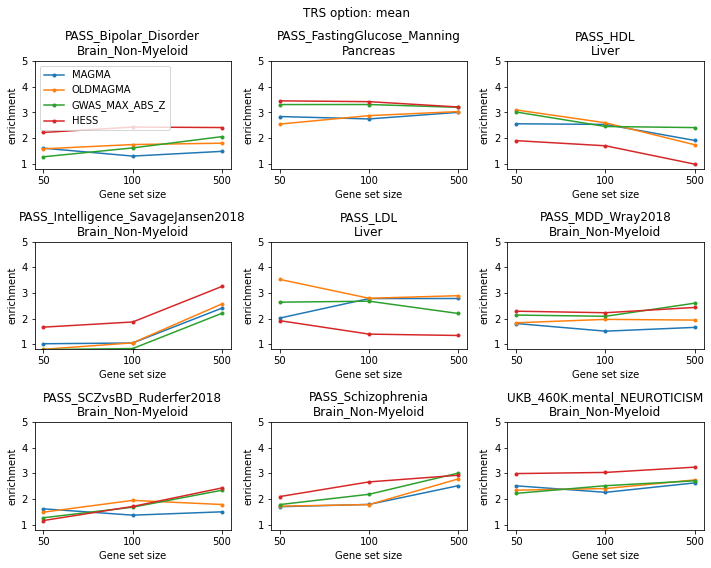

,trait,tissue,config,enrichment_mean,enrichment_sd,config_prefix
104,PASS_Bipolar_Disorder,Brain_Non-Myeloid,GWAS_MAX_ABS_Z_500,2.056397,0.020204,GWAS_MAX_ABS_Z
106,PASS_Bipolar_Disorder,Brain_Non-Myeloid,HESS_100,2.431007,0.014451,HESS
96,PASS_Bipolar_Disorder,Brain_Non-Myeloid,MAGMA_50,1.607338,0.006841,MAGMA
101,PASS_Bipolar_Disorder,Brain_Non-Myeloid,OLDMAGMA_500,1.801473,0.009135,OLDMAGMA
43,PASS_FastingGlucose_Manning,Pancreas,GWAS_MAX_ABS_Z_100,3.310083,0.031463,GWAS_MAX_ABS_Z
45,PASS_FastingGlucose_Manning,Pancreas,HESS_50,3.453093,0.040293,HESS
38,PASS_FastingGlucose_Manning,Pancreas,MAGMA_500,3.005314,0.012464,MAGMA
41,PASS_FastingGlucose_Manning,Pancreas,OLDMAGMA_500,3.035192,0.010108,OLDMAGMA
54,PASS_HDL,Liver,GWAS_MAX_ABS_Z_50,3.017553,0.009334,GWAS_MAX_ABS_Z
57,PASS_HDL,Liver,HESS_50,1.900988,0.013738,HESS


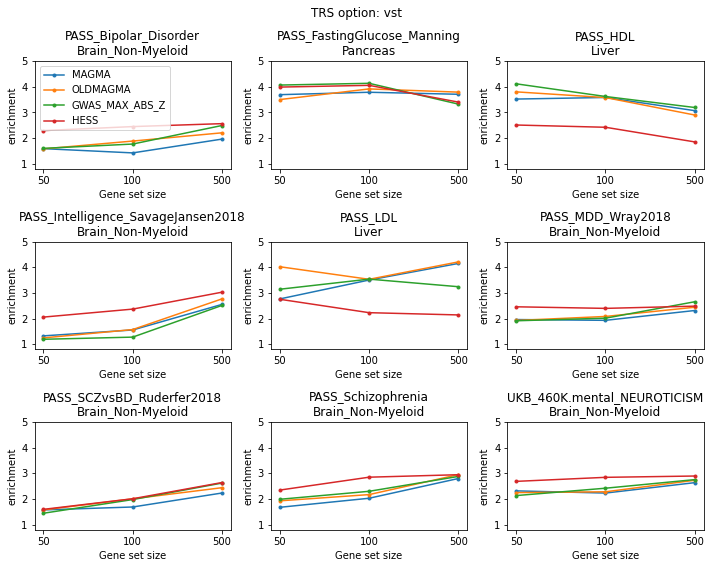

,trait,tissue,config,enrichment_mean,enrichment_sd,config_prefix
104,PASS_Bipolar_Disorder,Brain_Non-Myeloid,GWAS_MAX_ABS_Z_500,2.491407,0.023331,GWAS_MAX_ABS_Z
107,PASS_Bipolar_Disorder,Brain_Non-Myeloid,HESS_500,2.563903,0.006433,HESS
98,PASS_Bipolar_Disorder,Brain_Non-Myeloid,MAGMA_500,1.960927,0.011628,MAGMA
101,PASS_Bipolar_Disorder,Brain_Non-Myeloid,OLDMAGMA_500,2.205963,0.016134,OLDMAGMA
43,PASS_FastingGlucose_Manning,Pancreas,GWAS_MAX_ABS_Z_100,4.137988,0.084085,GWAS_MAX_ABS_Z
46,PASS_FastingGlucose_Manning,Pancreas,HESS_100,4.058101,0.030418,HESS
37,PASS_FastingGlucose_Manning,Pancreas,MAGMA_100,3.788423,0.034310,MAGMA
40,PASS_FastingGlucose_Manning,Pancreas,OLDMAGMA_100,3.918824,0.027774,OLDMAGMA
54,PASS_HDL,Liver,GWAS_MAX_ABS_Z_50,4.117087,0.179319,GWAS_MAX_ABS_Z
57,PASS_HDL,Liver,HESS_50,2.510521,0.087046,HESS


In [11]:
for trs_opt in all_dic_results:
    dic_results = all_dic_results[trs_opt]

    df = []

    # for each known association
    for _, assoc in known_association.iterrows():

        for config in config_list:

            if assoc.trait in dic_results[config]:
                enrichments = []
                for v_p in dic_results[config][assoc.trait]['trs_ep']:
                    enrichments.append(np.mean(np.log10(v_p[df_obs['tissue'] == assoc.tissue])) / np.mean(np.log10(v_p)))

                df.append([assoc.trait, assoc.tissue, config, np.mean(enrichments), np.std(enrichments)])

    df = pd.DataFrame(df, columns=['trait', 'tissue', 'config', 'enrichment_mean', 'enrichment_sd'])
    df['config_prefix'] = df['config'].apply(lambda x : x[0 : x.rfind('_')])

    grouped = df.groupby(['trait', 'tissue'])

    plt.figure(figsize=[10, 8])
    for i, (name, group) in enumerate(grouped):
        plt.subplot(int(np.ceil(len(grouped)/3)), 3,i + 1)
        for method in group['config_prefix'].unique():
            method_df = group[group['config_prefix'] == method]
            method_x = method_df['config'].apply(lambda x : x[x.rfind('_') + 1:])
            method_num = method_df['enrichment_mean']
            plt.plot(np.arange(len(method_x)), method_num, '.-', label=method)
            plt.xticks(np.arange(len(method_x)), method_x)
            plt.ylim([0.8, 5])
        if i == 0:
            plt.legend()
        plt.xlabel('Gene set size')
        plt.ylabel('enrichment')
        plt.title('\n'.join(name))
    plt.suptitle(f'TRS option: {trs_opt}')
    plt.tight_layout()
    plt.show()
    # max enrichment for different number of genes
    display(df.sort_values('enrichment_mean', ascending=False).drop_duplicates(['trait', 'tissue', 'config_prefix']).sort_values(['trait', 'tissue', 'config']))
    